In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import math

pd.set_option("display.min_rows", 20)

In [2]:
main_df = pd.read_json('../fediverse-stats.txt', orient='records', lines=True)
main_df

,endpoint,checked_target,result
0,https://ff.mizunashi.work/,ff.mizunashi.work,"{'type': 'ok', 'node_info': {'resource_type': ..."
1,https://atsuchan.page/,atsuchan.page,"{'type': 'ok', 'node_info': {'resource_type': ..."
2,https://m.huling.org/,m.huling.org,"{'type': 'ok', 'node_info': {'resource_type': ..."
3,https://types.pl/,types.pl,"{'type': 'ok', 'node_info': {'resource_type': ..."
4,https://lightcrystal.fedicity.net/,lightcrystal.fedicity.net,"{'type': 'ok', 'node_info': {'resource_type': ..."
5,https://ippandon.hopto.org/,ippandon.hopto.org,"{'type': 'ok', 'node_info': {'resource_type': ..."
6,https://social.wake.st/,social.wake.st,"{'type': 'ok', 'node_info': {'resource_type': ..."
7,https://labo.nora.social/,labo.nora.social,"{'type': 'ok', 'node_info': {'resource_type': ..."
8,https://a.gup.pe/,a.gup.pe,"{'type': 'ok', 'node_info': {'resource_type': ..."
9,https://hikoukidon.jp/,hikoukidon.jp,"{'type': 'ok', 'node_info': {'resource_type': ..."


In [3]:
result_df = pd.json_normalize(main_df['result'])
result_df

,type,peers_count,node_info.resource_type,node_info.resource_url,node_info.node_name,node_info.protocols,node_info.services_inbound,node_info.services_outbound,node_info.software_name,node_info.software_version,...,node_info.maintainer_name,node_info.open_registrations,node_info.email_required_for_signup,node_info.enable_email,node_info.enable_hcaptcha,node_info.enable_recaptcha,node_info.langs,node_info.max_note_text_length,resource_status,detail
0,ok,1423.0,http://nodeinfo.diaspora.software/ns/schema/2.1,https://ff.mizunashi.work/nodeinfo/2.1,Mizunashi Social,[activitypub],[],"[atom1.0, rss2.0]",firefish,1.0.4-beta31,...,Mizunashi Mana,False,False,True,False,True,[],3000.0,NaN,NaN
1,ok,NaN,http://nodeinfo.diaspora.software/ns/schema/2.0,https://atsuchan.page/nodeinfo/2.0,NaN,[activitypub],NaN,NaN,mastodon,3.4.10+glitch+atsu1125,...,maintenance,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ok,1020.0,http://nodeinfo.diaspora.software/ns/schema/2.1,https://m.huling.org/nodeinfo/2.1,Huling 鯖,[activitypub],[],"[atom1.0, rss2.0]",misskey,2023.10.0-poskey-4ba6f45,...,xiupos,False,False,False,False,False,[],3000.0,NaN,NaN
3,ok,NaN,http://nodeinfo.diaspora.software/ns/schema/2.0,https://types.pl/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.0+types,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ok,1501.0,http://nodeinfo.diaspora.software/ns/schema/2.0,https://lightcrystal.fedicity.net/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.1,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ok,6028.0,http://nodeinfo.diaspora.software/ns/schema/2.0,https://ippandon.hopto.org/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.1,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ok,29007.0,http://nodeinfo.diaspora.software/ns/schema/2.0,https://social.wake.st/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.1,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ok,124.0,http://nodeinfo.diaspora.software/ns/schema/2.0,https://labo.nora.social/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.1,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ok,NaN,http://nodeinfo.diaspora.software/ns/schema/2.1,https://a.gup.pe/nodeinfo/2.1,NaN,[activitypub],[],[],Guppe Groups,1.5.2,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ok,NaN,http://nodeinfo.diaspora.software/ns/schema/2.0,https://hikoukidon.jp/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.1,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = pd.DataFrame(result_df, columns=['type'])
df.loc[:, 'total'] = 1
df = df.pivot_table(index=['type'], aggfunc='count', values=['total'], margins=True)
df.loc[:, '%'] = (df['total'] / df.loc['All', 'total']) * 100
df.style.set_caption("Instances by Result Types")

,total,%
type,,
fail,54451,69.573495
ok,23813,30.426505
All,78264,100.000000


In [5]:
def detect_detail_kind(detail):
    if type(detail) is not str:
        return detail
    elif re.match(r'.* getaddrinfo ENOTFOUND ', detail):
        return 'Addr not found'
    elif re.match(r'.*/.well-known/nodeinfo: the resource is not available\.', detail):
        return '/.well-known/nodeinfo not found'
    elif re.match(r'.* timeout of [0-9]+ms exceeded', detail):
        return 'Timeout'
    elif re.match(r'.*(,| )(connect ENETUNREACH|connect EHOSTUNREACH)', detail):
        return 'Connection unreachable'
    elif re.match(r'.* (self-signed certificate|Hostname/IP does not match certificate\'s altnames|certificate has expired|unable to verify the first certificate|unable to get local issuer certificate)', detail):
        return 'TLS certificate is invalid'
    elif re.match(r'.* invalid status=(302|401|402|403|406|418|420|423|429|451|5[0-9]+|999)', detail):
        return 'Invalid HTTP status'
    elif re.match(r'.*(,| )connect ECONNREFUSED', detail):
        return 'Connection refused'
    elif re.match(r'.*/.well-known/nodeinfo: invalid schema.|JSON resources are not available on .*/.well-known/nodeinfo.', detail):
        return '/.well-known/nodeinfo invalid'
    elif re.match(r'.*:SSL routines:.*(:SSL alert number [0-9]+|:wrong version number|:unsupported protocol)', detail):
        return 'Not supported TLS'
    elif re.match(r'.*/.well-known/nodeinfo: the resource is gone\.', detail):
        return '/.well-known/nodeinfo gone'
    elif re.match(r'.* getaddrinfo EAI_AGAIN', detail):
        return 'Failed to resolve addr'
    elif re.match(r'.* Client network socket disconnected before secure TLS connection was established', detail):
        return 'Failed to handshake TLS sessions'
    elif re.match(r'.* (socket hang up|read ECONNRESET)', detail):
        return 'Connection cancelled'
    elif re.match(r'.*(,| )connect EINVAL', detail):
        return 'Connection invalid'
    elif re.match(r'.* Maximum number of redirects exceeded', detail):
        return 'Too many redirections'
    elif re.match(r'.* Parse Error', detail):
        return 'Not supported HTTP'
    else:
        return '_'

df = pd.DataFrame(result_df, columns=['type', 'resource_status', 'detail'])
df.loc[:, 'detail_kind'] = df['detail'].apply(detect_detail_kind)  
df.loc[:, 'total'] = 1
pivot_df = df.pivot_table(index=['type', 'detail_kind'], values=['total'], aggfunc='count').sort_values(by=['total'], ascending=False)
pivot_df.loc['All', 'total'] = pivot_df['total'].sum()
pivot_df.loc[:, '%'] = (pivot_df['total'] / pivot_df.loc['All', 'total'].iloc[0]) * 100
#df[(df['type']=='fail')&(df['detail_kind']=='_')]

pivot_df.style.set_caption("Instances by Failure Reasons to Fetch")

In [6]:
df = pd.DataFrame(result_df[result_df['type']=='ok'])
df = df.pivot_table(index='node_info.resource_type', values=[
    'node_info.resource_url', 
    'peers_count', 
    'node_info.users_total', 
    'node_info.users_active_month', 
    'node_info.users_active_half_year', 
    'node_info.local_posts_total',
    'node_info.local_comments_total',
    'node_info.open_registrations',
    'node_info.software_name',
    'node_info.software_version',
    'node_info.software_repository',
    'node_info.node_name',
    'node_info.max_note_text_length'
], aggfunc='count').rename(columns={
    'node_info.resource_url':'total',
})
df.loc['All'] = df.sum()
df = df.transpose()
df.loc[:, '%'] = (df.loc[:, 'All'] / df.loc[:, 'All']['total']) * 100
df.sort_values(by='All').rename(columns={
    'http://nodeinfo.diaspora.software/ns/schema/1.0':'nodeinfo/1.0',
    'http://nodeinfo.diaspora.software/ns/schema/2.0':'nodeinfo/2.0',
    'http://nodeinfo.diaspora.software/ns/schema/2.1':'nodeinfo/2.1'
}).style.set_caption("Instances Supported Features")

node_info.resource_type,nodeinfo/1.0,nodeinfo/2.0,nodeinfo/2.1,All,%
node_info.max_note_text_length,0,736,1200,1936,8.130013
node_info.software_repository,0,4,1959,1963,8.243396
node_info.node_name,394,5315,1262,6971,29.273926
node_info.local_comments_total,118,6014,1899,8031,33.725276
peers_count,353,13320,1297,14970,62.864822
node_info.users_active_month,119,16407,1149,17675,74.224163
node_info.users_active_half_year,119,16509,1154,17782,74.673498
node_info.local_posts_total,119,20761,2009,22889,96.119767
node_info.users_total,119,20943,2101,23163,97.270399
node_info.software_version,395,21298,2102,23795,99.924411


In [49]:
result_df[(result_df['type']=='ok')&result_df['peers_count'].isna()].pivot_table(
    index='node_info.software_name',
    values='node_info.resource_url', 
    aggfunc='count', 
    fill_value=0
).rename(columns={
    'node_info.resource_url':'instances_total'
}).sort_values(by='instances_total', ascending=False).head(20).style.set_caption('Top Softwares not Supported Peers API by Instances')

,instances_total
node_info.software_name,
wordpress,2510
peertube,1177
lemmy,1064
writefreely,704
gotosocial,659
mastodon,593
pixelfed,514
owncast,244
funkwhale,141


In [8]:
raw_ok_df = result_df[result_df['type']=='ok'].rename(columns={
    'node_info.users_total':'users_total',
    'node_info.users_active_month':'users_active_month',
    'node_info.users_active_half_year':'users_active_half_year',
    'node_info.local_posts_total':'local_posts_total',
    'node_info.local_comments_total':'local_comments_total',
    'node_info.open_registrations':'open_registrations',
    'node_info.software_name':'software_name',
    'node_info.software_version':'software_version',
    'node_info.node_name':'name'
})
raw_ok_df.loc[:, 'instances_total'] = 1
raw_ok_df[[
    'node_info.resource_url',
    'name',
    'software_name',
    'software_version',
    'users_total',
    'users_active_half_year',
    'users_active_month',
    'peers_count'
]].sort_values(by='users_total',ascending=False).head(20).style.set_caption('Top Instances by Users')

,node_info.resource_url,name,software_name,software_version,users_total,users_active_half_year,users_active_month,peers_count
12284,https://egirls.gay/nodeinfo/2.0,eGirls Dot Gay,misskey,12.91.0+egirls.4,1234567890.000000,nan,nan,2617.000000
1185,https://mastodon.social/nodeinfo/2.0,nan,mastodon,4.2.1,1644665.000000,837046.000000,283606.000000,63812.000000
130,https://pawoo.net/nodeinfo/2.0,nan,mastodon,4.1.6,925128.000000,58279.000000,49238.000000,37460.000000
50942,https://daystorm.netz.org/nodeinfo/2.0,nan,mastodon,4.1.2,479002.000000,479004.000000,479003.000000,nan
1277,https://mstdn.jp/nodeinfo/2.0,nan,mastodon,4.1.10,401999.000000,124252.000000,38723.000000,60633.000000
1401,https://misskey.io/nodeinfo/2.0,Misskey.io,misskey,13.14.2-io.11,399443.000000,nan,nan,22124.000000
48939,https://joindiaspora.com/nodeinfo/1.0,JoinDiaspora*,diaspora,1.0.0-dev-p5af17a0f,316111.000000,320.000000,74.000000,nan
124,https://baraag.net/nodeinfo/2.0,nan,mastodon,4.2.1,293188.000000,75809.000000,37530.000000,26857.000000
663,https://mastodon.cloud/nodeinfo/2.0,nan,mastodon,4.1.10,273693.000000,33593.000000,7552.000000,47955.000000
18642,https://pravda.me/nodeinfo/2.0,nan,mastodon,4.1.6,223407.000000,184795.000000,52550.000000,5224.000000


In [9]:
blacklist = [
    'https://egirls.gay/nodeinfo/2.0'
]
raw_ok_df[raw_ok_df['node_info.resource_url'].isin(blacklist)][[
    'name',
    'node_info.resource_type',
    'node_info.resource_url',
    'software_name',
    'software_version',
    'users_total',
    'users_active_half_year',
    'users_active_month',
    'local_posts_total',
    'local_comments_total',
    'peers_count'
]].style.set_caption('Ignored Noisy Instances')

,name,node_info.resource_type,node_info.resource_url,software_name,software_version,users_total,users_active_half_year,users_active_month,local_posts_total,local_comments_total,peers_count
12284,eGirls Dot Gay,http://nodeinfo.diaspora.software/ns/schema/2.0,https://egirls.gay/nodeinfo/2.0,misskey,12.91.0+egirls.4,1234567890.000000,nan,nan,696942069.000000,696942069.000000,2617.000000


In [10]:
ok_df = raw_ok_df[~raw_ok_df['node_info.resource_url'].isin(blacklist)]
ok_df

,type,peers_count,node_info.resource_type,node_info.resource_url,name,node_info.protocols,node_info.services_inbound,node_info.services_outbound,software_name,software_version,...,open_registrations,node_info.email_required_for_signup,node_info.enable_email,node_info.enable_hcaptcha,node_info.enable_recaptcha,node_info.langs,node_info.max_note_text_length,resource_status,detail,instances_total
0,ok,1423.0,http://nodeinfo.diaspora.software/ns/schema/2.1,https://ff.mizunashi.work/nodeinfo/2.1,Mizunashi Social,[activitypub],[],"[atom1.0, rss2.0]",firefish,1.0.4-beta31,...,False,False,True,False,True,[],3000.0,NaN,NaN,1
1,ok,NaN,http://nodeinfo.diaspora.software/ns/schema/2.0,https://atsuchan.page/nodeinfo/2.0,NaN,[activitypub],NaN,NaN,mastodon,3.4.10+glitch+atsu1125,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,ok,1020.0,http://nodeinfo.diaspora.software/ns/schema/2.1,https://m.huling.org/nodeinfo/2.1,Huling 鯖,[activitypub],[],"[atom1.0, rss2.0]",misskey,2023.10.0-poskey-4ba6f45,...,False,False,False,False,False,[],3000.0,NaN,NaN,1
3,ok,NaN,http://nodeinfo.diaspora.software/ns/schema/2.0,https://types.pl/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.0+types,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,ok,1501.0,http://nodeinfo.diaspora.software/ns/schema/2.0,https://lightcrystal.fedicity.net/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.1,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,ok,6028.0,http://nodeinfo.diaspora.software/ns/schema/2.0,https://ippandon.hopto.org/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.1,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,ok,29007.0,http://nodeinfo.diaspora.software/ns/schema/2.0,https://social.wake.st/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.1,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,ok,124.0,http://nodeinfo.diaspora.software/ns/schema/2.0,https://labo.nora.social/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.1,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,ok,NaN,http://nodeinfo.diaspora.software/ns/schema/2.1,https://a.gup.pe/nodeinfo/2.1,NaN,[activitypub],[],[],Guppe Groups,1.5.2,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,ok,NaN,http://nodeinfo.diaspora.software/ns/schema/2.0,https://hikoukidon.jp/nodeinfo/2.0,NaN,[activitypub],[],[],mastodon,4.2.1,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [11]:
pd.DataFrame(
    ok_df.loc[:, [
        'instances_total',
        'users_total', 
        'users_active_half_year', 
        'users_active_month', 
        'local_posts_total', 
        'local_comments_total'
    ]].sum().astype(int),
    columns=['total']
)

,total
instances_total,23812
users_total,12034116
users_active_half_year,3843988
users_active_month,1812074
local_posts_total,1164902358
local_comments_total,25175892


<Axes: title={'center': 'Users Percentiles by Instances'}, xlabel='instances_percent', ylabel='users_total'>

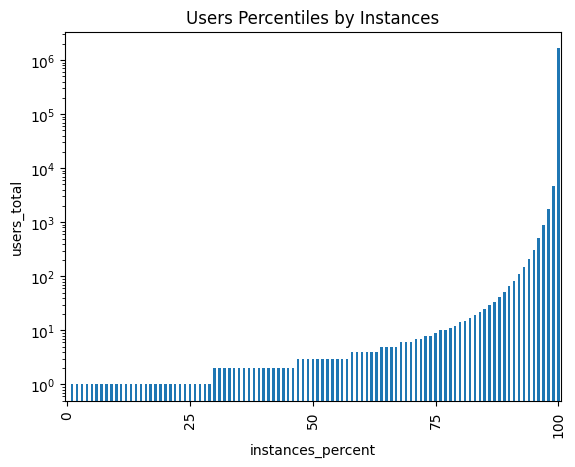

In [12]:
df = ok_df[['users_total']].quantile(list(map(lambda x: x / 100, range(101))))
df.reset_index(inplace=True)
df = df.rename(columns={
    'index':'instances_ratio',
})
df['instances_percent'] = df['instances_ratio'] * 100
df.plot.bar(
    x='instances_percent', 
    y='users_total', 
    logy=True, 
    xticks=[0, 25, 50, 75, 100], 
    legend=False, 
    ylabel='users_total',
    title='Users Percentiles by Instances'
)

<Axes: title={'center': 'Posts Percentiles by Instances'}, xlabel='instances_percent', ylabel='local_posts_total'>

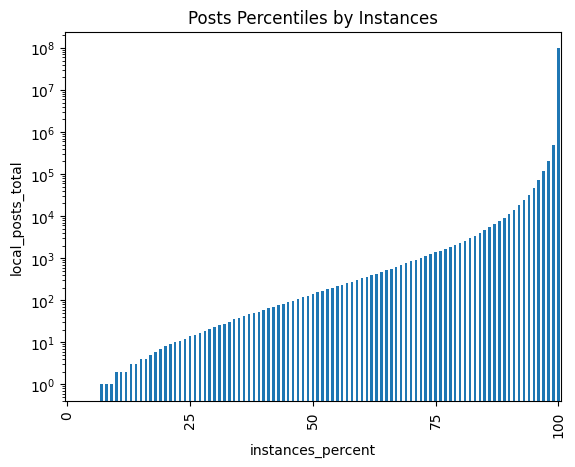

In [13]:
df = ok_df[['local_posts_total']].quantile(list(map(lambda x: x / 100, range(101))))
df.reset_index(inplace=True)
df = df.rename(columns={
    'index':'instances_ratio',
})
df['instances_percent'] = df['instances_ratio'] * 100
df.plot.bar(
    x='instances_percent',
    y='local_posts_total',
    logy=True,
    xticks=[0, 25, 50, 75, 100],
    legend=False,
    ylabel='local_posts_total',
    title='Posts Percentiles by Instances'
)

<Axes: title={'center': 'Peers Percentiles by Instances'}, xlabel='instances_percent', ylabel='peers_count'>

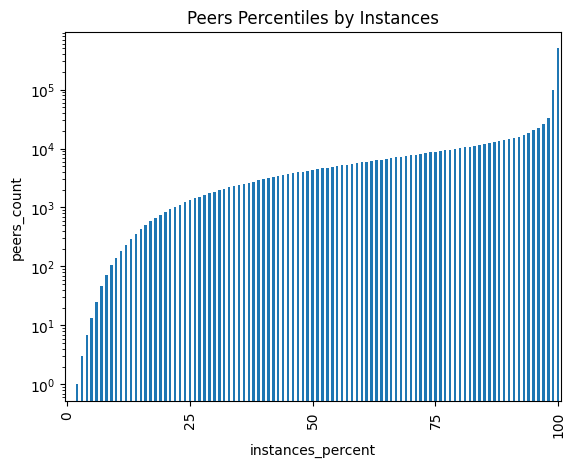

In [14]:
df = ok_df[['peers_count']].quantile(list(map(lambda x: x / 100, range(101))))
df.reset_index(inplace=True)
df = df.rename(columns={
    'index':'instances_ratio',
})
df['instances_percent'] = df['instances_ratio'] * 100
df.plot.bar(
    x='instances_percent', 
    y='peers_count', 
    logy=True, 
    xticks=[0, 25, 50, 75, 100], 
    legend=False, 
    ylabel='peers_count',
    title='Peers Percentiles by Instances'
)

<Axes: title={'center': 'Users Active Month Percentiles by Instances'}, xlabel='instances_percent', ylabel='users_active_month'>

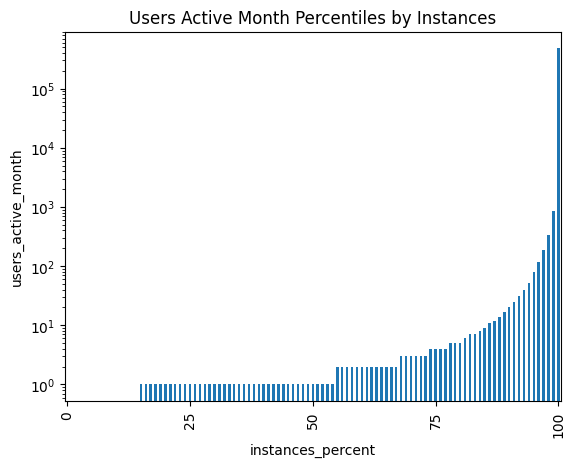

In [15]:
df = ok_df[['users_active_month']].quantile(list(map(lambda x: x / 100, range(101))))
df.reset_index(inplace=True)
df = df.rename(columns={
    'index':'instances_ratio',
})
df['instances_percent'] = df['instances_ratio'] * 100
df.plot.bar(
    x='instances_percent',
    y='users_active_month', 
    logy=True, 
    xticks=[0, 25, 50, 75, 100], 
    legend=False, 
    ylabel='users_active_month',
    title='Users Active Month Percentiles by Instances'
)

In [16]:
ok_df.pivot_table(index='software_name', values=[
    'instances_total',
    'users_total',
    'users_active_half_year', 
    'users_active_month', 
    'local_posts_total', 
    'local_comments_total'
], aggfunc='sum').sort_values(by=['instances_total'],ascending=False).head(20)

,instances_total,local_comments_total,local_posts_total,users_active_half_year,users_active_month,users_total
software_name,,,,,,
mastodon,11036,0.0,841041533.0,3260468.0,1637704.0,8412565.0
wordpress,2691,2860881.0,2563020.0,384.0,253.0,45812.0
misskey,1262,0.0,99163127.0,11158.0,3283.0,759766.0
peertube,1177,373260.0,20782250.0,80674.0,38829.0,295527.0
pleroma,1130,0.0,26116001.0,33435.0,12675.0,139273.0
lemmy,1064,9395508.0,4767486.0,101337.0,33305.0,817441.0
writefreely,704,0.0,329599.0,11845.0,1538.0,72825.0
gotosocial,690,0.0,533240.0,0.0,0.0,1235.0
akkoma,562,0.0,4339900.0,14915.0,4195.0,15833.0


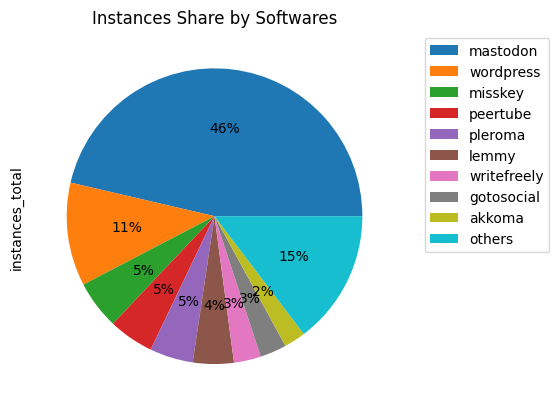

In [17]:
all_df = ok_df.pivot_table(index='software_name', values='instances_total', aggfunc='sum').sort_values(by='instances_total', ascending=False)
df = pd.DataFrame(all_df.head(9))
df.loc['others'] = all_df[9:].sum()
plot = df.plot.pie(y='instances_total', autopct='%.f%%', labeldistance=None, title='Instances Share by Softwares')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

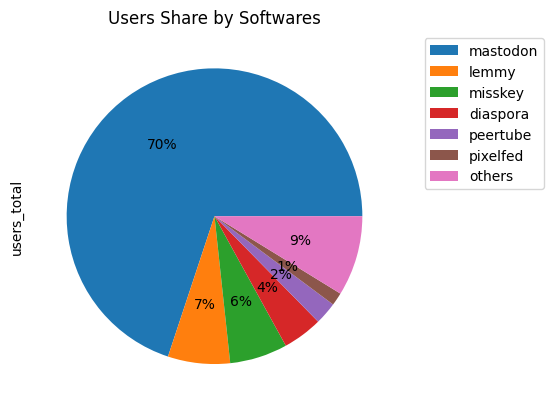

In [18]:
all_df = ok_df.pivot_table(index='software_name', values='users_total', aggfunc='sum').sort_values(by='users_total', ascending=False)
df = pd.DataFrame(all_df.head(6))
df.loc['others'] = all_df[6:].sum()
plot = df.plot.pie(y='users_total', autopct='%.f%%', labeldistance=None, title='Users Share by Softwares')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

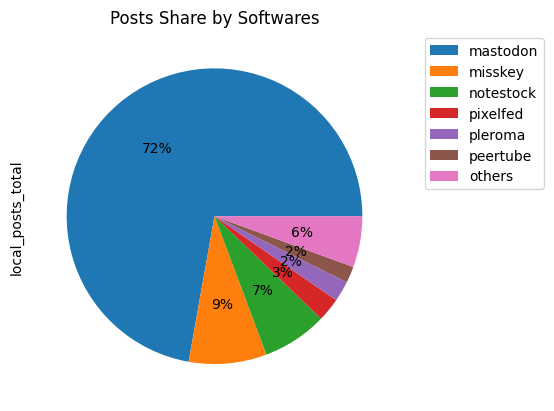

In [19]:
all_df = ok_df.pivot_table(index='software_name', values='local_posts_total', aggfunc='sum').sort_values(by='local_posts_total', ascending=False)
df = pd.DataFrame(all_df.head(6))
df.loc['others'] = all_df[6:].sum()
plot = df.plot.pie(y='local_posts_total', autopct='%.f%%', labeldistance=None, title='Posts Share by Softwares')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

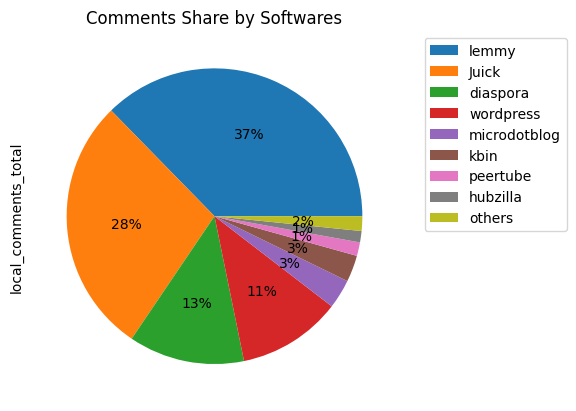

In [20]:
all_df = ok_df.pivot_table(index='software_name', values='local_comments_total', aggfunc='sum').sort_values(by='local_comments_total', ascending=False)
df = pd.DataFrame(all_df.head(8))
df.loc['others'] = all_df[8:].sum()
plot = df.plot.pie(y='local_comments_total', autopct='%.f%%', labeldistance=None, title='Comments Share by Softwares')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

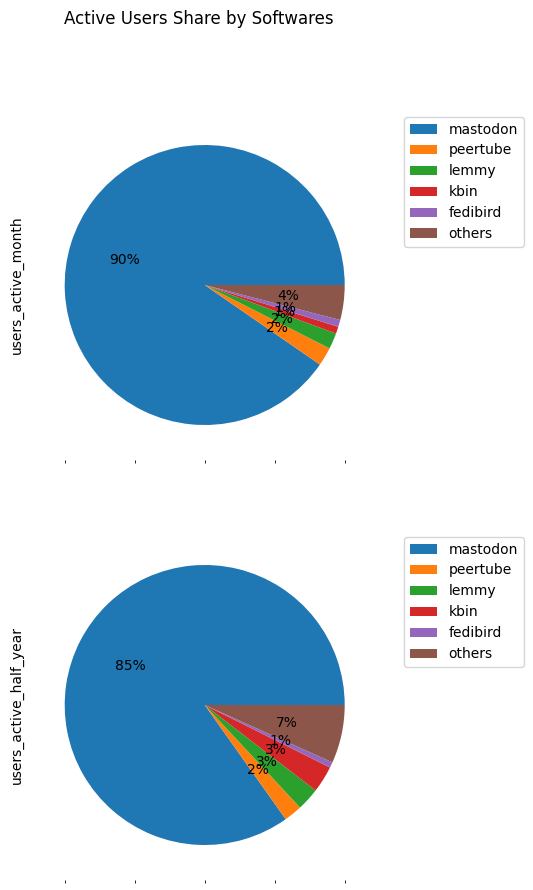

In [21]:
all_df = ok_df.pivot_table(index='software_name', values=[
    'users_active_month',
    'users_active_half_year'
], aggfunc='sum')[[
    'users_active_month',
    'users_active_half_year'
]].sort_values(by='users_active_month', ascending=False)
df = pd.DataFrame(all_df.head(5))
df.loc['others'] = all_df[5:].sum()
plots = df.plot.pie(subplots=True, autopct='%.f%%', labeldistance=None, layout=(2, 1), figsize=(5, 10), title='Active Users Share by Softwares')
for plot in plots:
    plot[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

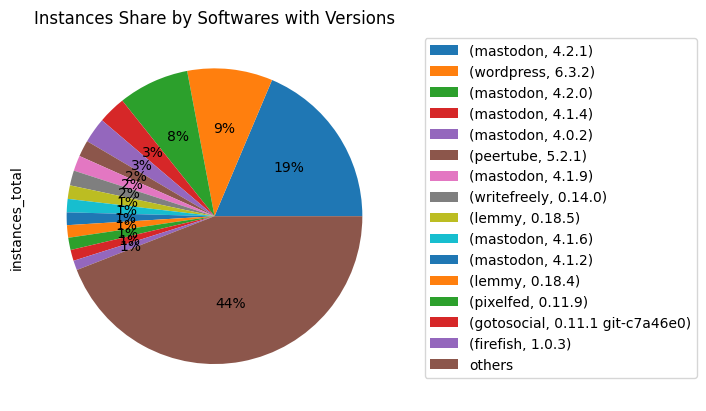

In [22]:
all_df = ok_df.pivot_table(index=['software_name', 'software_version'], values='instances_total', aggfunc='sum').sort_values(by='instances_total', ascending=False)
df = pd.DataFrame(all_df.head(15))
df.loc['others'] = all_df[15:].sum()
plot = df.plot.pie(y='instances_total', autopct='%.f%%', labeldistance=None, title='Instances Share by Softwares with Versions')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

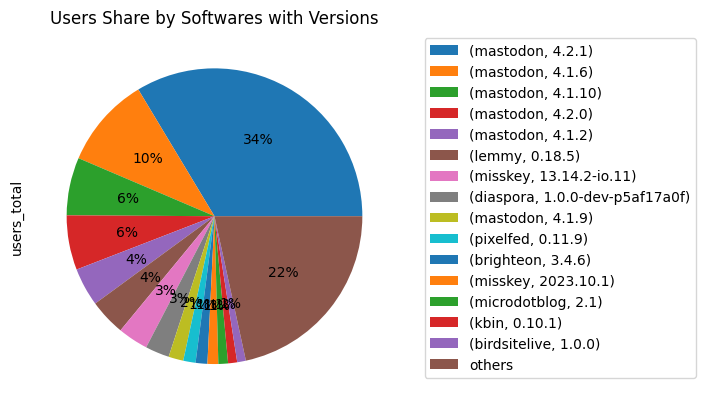

In [23]:
all_df = ok_df.pivot_table(index=['software_name', 'software_version'], values='users_total', aggfunc='sum').sort_values(by='users_total', ascending=False)
df = pd.DataFrame(all_df.head(15))
df.loc['others'] = all_df[15:].sum()
plot = df.plot.pie(y='users_total', autopct='%.f%%', labeldistance=None, title='Users Share by Softwares with Versions')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

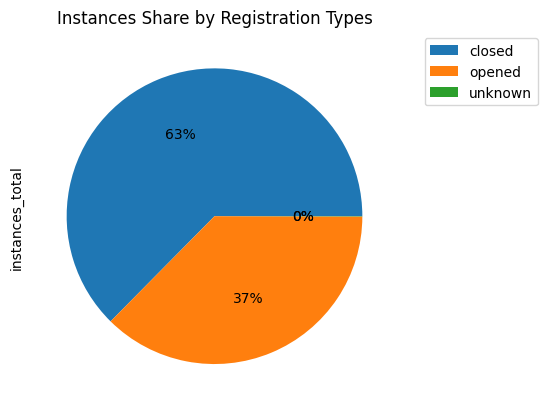

In [24]:
def registration_type(open_registrations):
    if type(open_registrations) is not bool:
        return 'unknown'
    elif open_registrations:
        return 'opened'
    else:
        return 'closed'

all_df = pd.DataFrame(ok_df)
all_df['registration_type'] = ok_df['open_registrations'].apply(registration_type)
all_df = all_df.pivot_table(
    index='registration_type',
    values='instances_total', 
    aggfunc='sum'
).sort_values(by='instances_total', ascending=False)
df = pd.DataFrame(all_df.head(9))
df.loc['others'] = all_df[9:].sum()
plot = df.plot.pie(y='instances_total', autopct='%.f%%', labeldistance=None, title='Instances Share by Registration Types')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

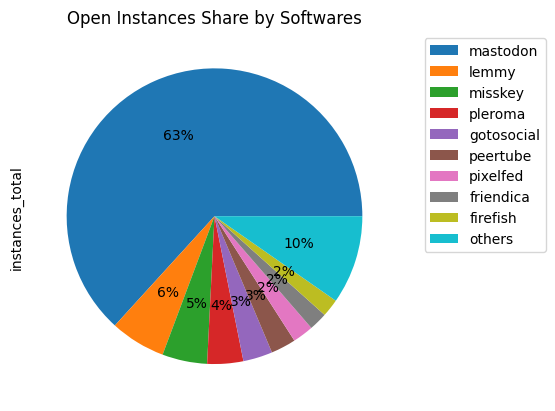

In [25]:
all_df = ok_df[ok_df['open_registrations'].fillna(False)].pivot_table(
    index='software_name', 
    values='instances_total', 
    aggfunc='sum'
).sort_values(by='instances_total', ascending=False)
df = pd.DataFrame(all_df.head(9))
df.loc['others'] = all_df[9:].sum()
plot = df.plot.pie(y='instances_total', autopct='%.f%%', labeldistance=None, title='Open Instances Share by Softwares')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

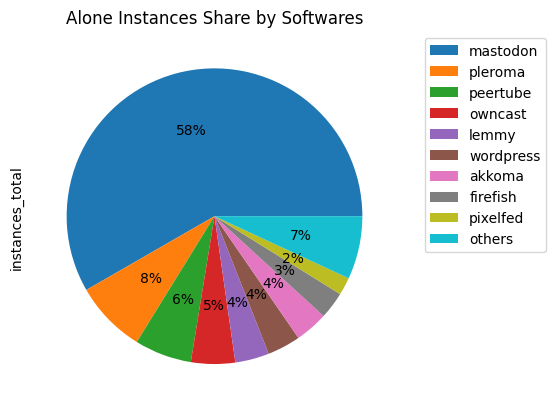

In [26]:
all_df = ok_df[(~ok_df['open_registrations'].fillna(False))&(ok_df['users_active_month']==1|(ok_df['users_active_month'].isna()&(ok_df['users_total'] <= 5)))].pivot_table(
    index='software_name', 
    values='instances_total', 
    aggfunc='sum'
).sort_values(by='instances_total', ascending=False)
df = pd.DataFrame(all_df.head(9))
df.loc['others'] = all_df[9:].sum()
plot = df.plot.pie(y='instances_total', autopct='%.f%%', labeldistance=None, title='Alone Instances Share by Softwares')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')